In [1]:
import random
import matplotlib.pyplot as plt
import math
from math import comb

In [2]:
# Gives every 0 or 1 (discard or keep) combination for the number of dice we trow.
def dynamic_loop(depth, current_depth=0, current_combination=[], result=None):
    global i
    if result is None:
        result = {}
        i = 0
    
    if current_depth == depth:
        result[i] = current_combination
        i += 1
        return result
    
    #Keep or discard: Where 0 is discard and 1 is keep
    
    for value in [0,1]:
        dynamic_loop(depth, current_depth + 1, current_combination + [value], result)
    
    return result


In [3]:
# Function for removing non-available dice (and keepList position)
def getAllAvailableDice(dice, keepList, available):
    
    diceCopy = dice.copy()
    keepListCopy = keepList.copy()

    # Collect indices to remove, we only want to remove if we wish to keep the dice
    indices_to_remove = []
    for i, d in enumerate(dice):
        if d not in available and keepList[i] == 1:
            indices_to_remove.append(i)
            
    # Remove in reverse order, (preserve the indexes)
    for i in sorted(indices_to_remove, reverse=True):
        del diceCopy[i]
        del keepListCopy[i]
    
    return diceCopy, keepListCopy

In [4]:
def xOfAKind(x, keepList, dice):

    #Return 0 if theres less dice available to us, than what we want.
    if len(dice) < x:
        return [0], 0.0
    
    # If a number in keepList is 1, we keep otherwise we HAVE to throw it.
    # Count all number we keep and throw.
    keepDict = {}
    unique = 0
    keepAmount = 0
    throwAmout = 0
    
    for i, keep in enumerate(keepList):
        if keep == 0:
            throwAmout += 1
        else:
            keepAmount += 1
            if dice[i] in keepDict:
                keepDict[dice[i]] += 1
            else:
                keepDict[dice[i]] = 1
                unique += 1

    # Check the keepDict for highest x of a kind.
    tmpK = 0
    for key, value in keepDict.items():
        if value >= x:
            if key > tmpK:
                tmpK = key
    if tmpK != 0: 
        return [tmpK], 1.0
    
    # In case we dont want to keep any dice, for example keepDice = [0,0,0]
    # Return all options and the chance of x of a kind.
    if unique == 0:
        return available, ((1/6)**x)

    # Probability of rolling a specific number on a die
    p_outcome = unique / 6
    n_p_outcome = 1-p_outcome

    # n = number of dice we're rolling
    # k = number of additional dice needed to match the value we're aiming for
    n = throwAmout
    k = int(x-(keepAmount/unique))

    results = (comb(n, k))*(p_outcome**k)*(n_p_outcome**(n-k))

    keys = list(keepDict.keys())

    return keys, results

In [5]:
# Calculating the probability of getting num, given that we're keeping the numbers in keepList
def inference(keepList, dice, available):
    inf = 0
    di = 0
    
    diceCopy, keepListCopy = getAllAvailableDice(dice, keepList, available)
    
    # Calculate Chance of 1 of a kind, 2 of a kind ... n of a kind and add to inf
    for i in range(1,len(dice)+1):
        d, p = xOfAKind(i, keepListCopy, diceCopy)
        
        # take the average of the numbers returned times with the probability times the number of similar. 
        score = p
        
        # add the score to the total inference
        inf += score 
        
    return inf, keepList, dice

In [6]:
# Reroll all dice that we do not want to keep.
def reroll(dice, keepList):
    diceC = dice.copy()
    for i in range(len(keepList)):
        if keepList[i] == 0:
            diceC[i] = random.randint(1, 6)

    return diceC

In [7]:
from collections import Counter

# Do a starting roll -> the first inference and decision -> the second inference and decision
# Return the dice we kept, and how many we got.

def oneRound(numberOfDice, available):
    # A dict of all combinations
    combinations_dict = dynamic_loop(numberOfDice)
    dice = []
    keepDice = 0
    keepList = []
    topInf = 0

    # Initial roll, roll all num of dice
    for _ in range(numberOfDice):
        dice.append(random.randint(1, 6))
    

    # Custom dice for testing purposes.
    # dice = [2, 2, 2, 2, 5]

    # Do inference on all combinations of "keep or discard" with the current dice
    for combination in combinations_dict.items():
        inf, kL, d = inference(combination[1], dice, available)
        if inf > topInf:
            keepList = kL
            topInf = inf
    
    
    dice = reroll(dice, keepList)


    # Do inference on all combinations of "keep or discard" with the current dice
    for combination in combinations_dict.items():
        inf, kL, d = inference(combination[1], dice, available)
        if inf > topInf:
            keepList = kL
            topInf = inf
    dice = reroll(dice, keepList)

    # Do inference on all combinations of "keep or discard" with the current dice
    for combination in combinations_dict.items():
        inf, kL, d = inference(combination[1], dice, available)
        if inf > topInf:
            keepList = kL
            topInf = inf
    
    # We have no choice but to keep all this stage.
    diceCopy, keepListCopy = getAllAvailableDice(d, [1,1,1,1,1], available)

    # We might not have rolled any available dice, so we should check for this.
    # If this is the case, return the first element in the available list.
    if not diceCopy:
        return available[0], 0

    # Return the most occuring dice
    counter = Counter(diceCopy)
    maxOccuringDice, amount = counter.most_common(1)[-1]

    return maxOccuringDice, amount


In [8]:
# Run time with repeat=400000 : ~ 13 min
numberOfDice = 5
repeat = 400000
games_score = {}
times_yahtzee = 0
times_yahtzee_and_63 = 0
totalScore = 0
ytziTimes = 0

for _ in range(repeat):
    available = [1, 2, 3, 4, 5, 6]
    ytzi = False
    score = 0
    for i in range(6):
        kept, amount = oneRound(numberOfDice, available)
        if (amount == numberOfDice) and not ytzi:
            ytzi = True
            ytziTimes += 1
        else:
            available.remove(kept)
            score += kept*amount

    totalScore += score

    if (ytzi) and (score >= 63):
        times_yahtzee_and_63 += 1

    if score not in games_score:
        games_score[score] = 1
    else:
        games_score[score] += 1

AVG score after 400000 games : 53.0903825
Times player got yahtzee : 54054
Times player got yahtzee and over 63 : 2502

Percentage of games :: Score over 63 : 13.0%
percentage of games :: yahtzee : 13.5%
percentage of games :: yahtzee and score over 63 : 0.6%


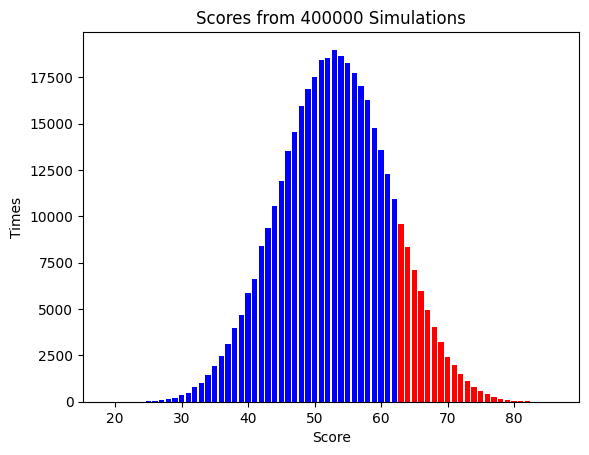

In [9]:
# Benchmark from our decision tree inference and decision

print(f"AVG score after {repeat} games : {totalScore/repeat}")
print(f"Times player got yahtzee : {ytziTimes}")
print(f"Times player got yahtzee and over 63 : {times_yahtzee_and_63}")
print("")

Ysum = 0
for key, value in games_score.items():
    if key >= 63:
        Ysum += value

print(f"Percentage of games :: Score over 63 : {round((Ysum/repeat),2)*100}%")
print(f"percentage of games :: yahtzee : {round((ytziTimes/repeat),3)*100}%")
print(f"percentage of games :: yahtzee and score over 63 : {round((times_yahtzee_and_63/repeat),3)*100}%")
# Plotting the scores from games_score
colors = ['red' if score >= 63 else 'blue' for score in games_score.keys()]
plt.bar(games_score.keys(), games_score.values(), color=colors)
plt.xlabel('Score')
plt.ylabel('Times')
plt.title(f'Scores from {repeat} Simulations')
plt.show()